In [1]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append('artifactory/')

In [2]:
import pickle
from itertools import repeat
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
# from detector import WindowTransformerDetector

In [82]:
from lightning.pytorch import seed_everything
import lightning.pytorch as pl

seed_everything(42, workers=True)

Global seed set to 42


42

In [83]:
from abc import ABC, abstractmethod
from typing import Any, Tuple


import numpy as np


class Artifact(ABC):
    """Base class for artifacts."""

    def __init__(self, min_width: int = 3, max_width: int = 59) -> None:
        self.min_width = min_width
        self.max_width = max_width
        self.generator = np.random.default_rng()

    @abstractmethod
    def generate(self, min_rate: float, max_rate: float) -> np.ndarray:
        pass


class Saw(Artifact):
    """Sawtooth artifact."""

    def generate(
        self, min_width: int = 1, min_rate=0.00023, max_rate=0.387
    ) -> np.ndarray:
        width = self.generator.integers(min_width, self.max_width, endpoint=True)
        if width > 2:
            activation = self.generator.integers(width)
            rate = self.generator.uniform(min_rate, max_rate) * np.sign(
                self.generator.uniform(-1, 1)
            )
            time = np.arange(width)
            ramp = rate * time
            return ramp - (rate * (width - 1) * (time >= activation))
        else:
            return [0]



class Saw_centered(Artifact):
    """Sawtooth artifact."""

    def generate(
        self, min_width: int = 3, min_rate=0.00023, max_rate=0.387
    ) -> Tuple[Any, int]:
        width = self.generator.integers(min_width, self.max_width, endpoint=True)
        activation = self.generator.integers(width)
        rate = self.generator.uniform(min_rate, max_rate) * np.sign(
            self.generator.uniform(-1, 1)
        )
        time = np.arange(width)
        ramp = rate * time
        return ramp - (rate * (width - 1) * (time >= activation)), activation

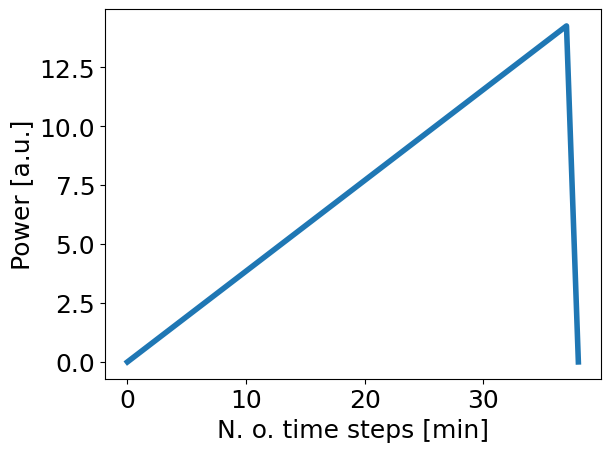

In [85]:
import matplotlib.pyplot as plt

artifact = Saw_centered()

a = artifact.generate()
plt.rcParams.update({'font.size': 18})
plt.plot(a[0], linewidth = 4)
plt.xlabel('N. o. time steps [min]') 
plt.ylabel("Power [a.u.]")
plt.show()

In [86]:
width = 512

"""
returns: list of list of arrays containing the time series in the datasets in names
    only adds the series that are longer than the provided width (1024)
returns: weights for the time series in the list according to number of time series in the dataset
    all datasets are sampled at the same rate
"""
def load_series(names: list[str], split: str, path: str):
    series: list[np.ndarray] = list()
    counts: list[float] = list()
    for name in names:
        with open(f"{path}/{name}_{split}.pickle", "rb") as f:
            raw = [a for a in pickle.load(f) if len(a) > width]
            series.extend(np.array(a).astype(np.float32) for a in raw)
            counts.extend(repeat(1 / len(raw), len(raw)))
    counts = np.array(counts)
    return series, np.divide(counts, np.sum(counts))


In [87]:
AuElDe, AuElDe_weights = load_series(["australian_electricity_demand_dataset"], "TRAIN", path="data/processed_2")
ElHo, ElHo_weights = load_series(["electricity_hourly_dataset"], "TRAIN", path="data/processed_2")


In [88]:
# TODO: how long is the width of an artifact in the real data?
# How "big" are the artifacts compared to the surrounding data?
from data import RealisticArtifactDataset, CenteredArtifactDataset, CachedArtifactDataset

AuElDe_mask_dataset = RealisticArtifactDataset(AuElDe,
                          Saw(min_width=3, max_width=59),
                          width=width,
                          padding=64,
                          weight=AuElDe_weights)

ElHo_mask_dataset = RealisticArtifactDataset(ElHo,
                          Saw(min_width=3, max_width=59),
                          width=width,
                          padding=64,
                          weight=ElHo_weights)

AuElDe_SW_dataset = CenteredArtifactDataset(AuElDe,
                          Saw_centered(min_width=3, max_width=59),
                          width=width,
                          padding=64,
                          weight=AuElDe_weights,
                          p_has_artifact=1)

ElHo_SW_dataset = CenteredArtifactDataset(ElHo,
                          Saw_centered(min_width=3, max_width=59),
                          width=width,
                          padding=64,
                          weight=ElHo_weights,
                          p_has_artifact=1)

In [89]:
from torch.utils.data import DataLoader

AuElDe_mask_loader = DataLoader(AuElDe_mask_dataset, batch_size=32)
AuElDe_SW_loader = DataLoader(AuElDe_SW_dataset, batch_size=32)
ElHo_mask_loader = DataLoader(ElHo_mask_dataset, batch_size=32)
ElHo_SW_loader = DataLoader(ElHo_SW_dataset, batch_size=32)

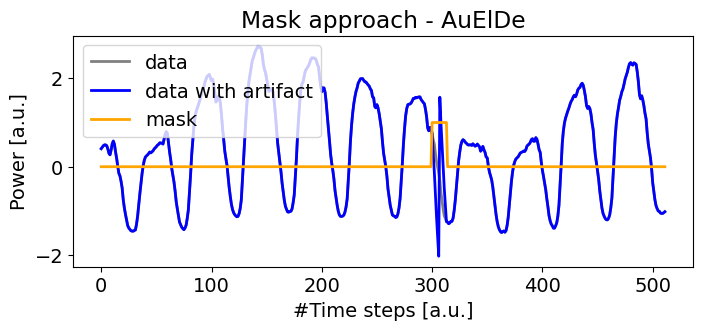

In [98]:
# AuElDe_mask_sample = next(iter(AuElDe_mask_loader))
# AuElDe_mask_sample = next(iter(AuElDe_mask_loader))
sample = AuElDe_mask_sample
plt.figure(figsize=(8, 3))
plt.plot(sample["data"][0], label="data", linewidth=2.0, color="grey")
plt.plot(sample["data"][0] + sample["artifact"][0], label="data with artifact", linewidth=2.0, color="blue")
plt.plot(sample["mask"][0], label="mask", linewidth=2.0, color="orange")

plt.title("Mask approach - AuElDe")
plt.xlabel("#Time steps [a.u.]")
plt.ylabel("Power [a.u.]")
plt.rcParams.update({'font.size': 14})

plt.legend(loc=2)
plt.show(block=True)

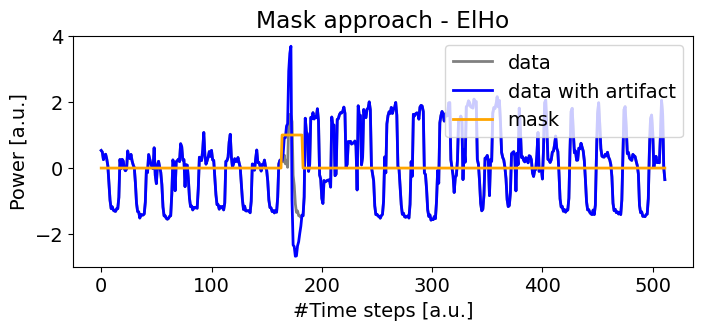

In [93]:
# ElHo_mask_sample = next(iter(ElHo_mask_loader))
sample = ElHo_mask_sample
plt.figure(figsize=(8, 3))
plt.plot(sample["data"][0], label="data", linewidth=2.0, color="grey")
plt.plot(sample["data"][0] + sample["artifact"][0], label="data with artifact", linewidth=2.0, color="blue")
plt.plot(sample["mask"][0], label="mask", linewidth=2.0, color="orange")

plt.title("Mask approach - ElHo")
plt.xlabel("#Time steps [a.u.]")
plt.ylabel("Power [a.u.]")
plt.rcParams.update({'font.size': 14})

plt.legend(loc=1)
plt.show(block=True)

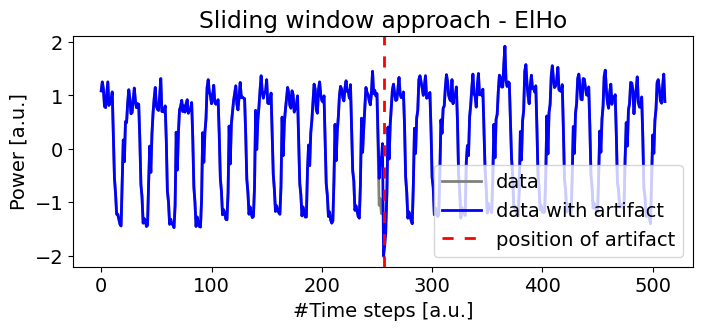

In [94]:
ElHo_SW_sample = next(iter(ElHo_SW_loader))
sample = ElHo_SW_sample
plt.figure(figsize=(8, 3))
plt.plot(sample["data"][0], label="data", linewidth=2.0, color="grey")
plt.plot(sample["data"][0] + sample["artifact"][0], label="data with artifact", linewidth=2.0, color="blue")
plt.axvline(x=256, c="red", linestyle="--", linewidth=2.0, dashes=(4,4), label="position of artifact")

plt.title("Sliding window approach - ElHo")
plt.xlabel("#Time steps [a.u.]")
plt.ylabel("Power [a.u.]")
plt.rcParams.update({'font.size': 14})

plt.legend()
plt.show(block=True)

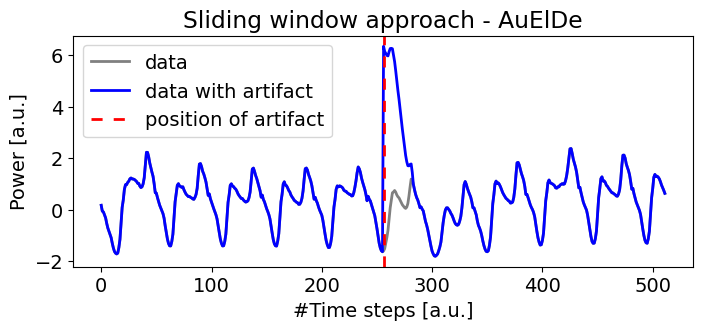

In [96]:
AuElDe_SW_sample = next(iter(AuElDe_SW_loader))
sample = AuElDe_SW_sample
plt.figure(figsize=(8, 3))
plt.plot(sample["data"][0], label="data", linewidth=2.0, color="grey")
plt.plot(sample["data"][0] + sample["artifact"][0], label="data with artifact", linewidth=2.0, color="blue")
plt.axvline(x=256, c="red", linestyle="--", linewidth=2.0, dashes=(4,4), label="position of artifact")

plt.title("Sliding window approach - AuElDe")
plt.xlabel("#Time steps [a.u.]")
plt.ylabel("Power [a.u.]")
plt.rcParams.update({'font.size': 14})

plt.legend(loc=2)
plt.show(block=True)

<Figure size 800x600 with 0 Axes>

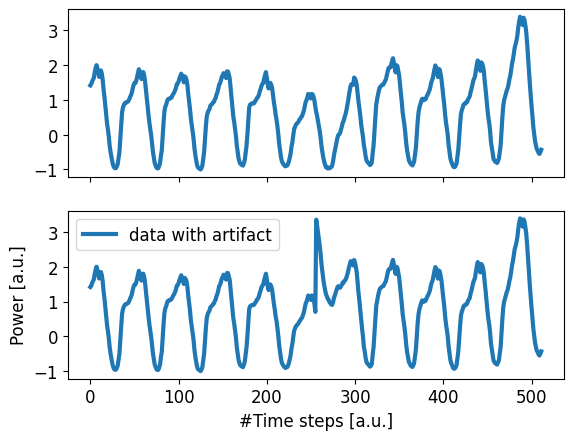

In [33]:
plt.figure(figsize=(8, 3))
fig, axs = plt.subplots(2, sharex=True, sharey=True)
# fig.suptitle('example artifact')
axs[0].plot(sample["data"][0], label="data", linewidth=3.0)
axs[1].plot(sample["data"][0] + sample["artifact"][0], label="data with artifact", linewidth=3.0)
# axs[1].plot(sample["mask"][0], label="mask", linewidth=3.0)
# Changing the fontsize of yticks for both plots
for ax in axs:
    ax.tick_params(axis='y')

# Changing the fontsize of xticks for both plots
for ax in axs:
    ax.tick_params(axis='x')

plt.xlabel("#Time steps [a.u.]")
plt.ylabel("Power [a.u.]")
plt.rcParams.update({'font.size': 12})

plt.legend()
plt.show(block=True)